# PREDICTIVE ANALYSIS

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
import seaborn as sns


# 1. LOAD THE DATASETS



In [34]:
files = [
    'Team8_PyMasters_Cleaned_data1.xlsx',
    'Team8_PyMasters_Cleaned_data2.xlsx',
    'Team8_PyMasters_Cleaned_data3.xlsx'
]

dfs = [pd.read_excel(f) for f in files]
df1, df2, df3 = dfs

Correlation with Month (Time Trend):
probable                 NaN
vulnerable               NaN
is_most_recent           NaN
fever_chills_shakes      NaN
cough                    NaN
shortness_of_breath      NaN
any_medical_conditions   NaN
travel_outside_canada    NaN
contact_with_illness     NaN
age_binary               NaN
month_numeric            NaN
Name: month_numeric, dtype: float64


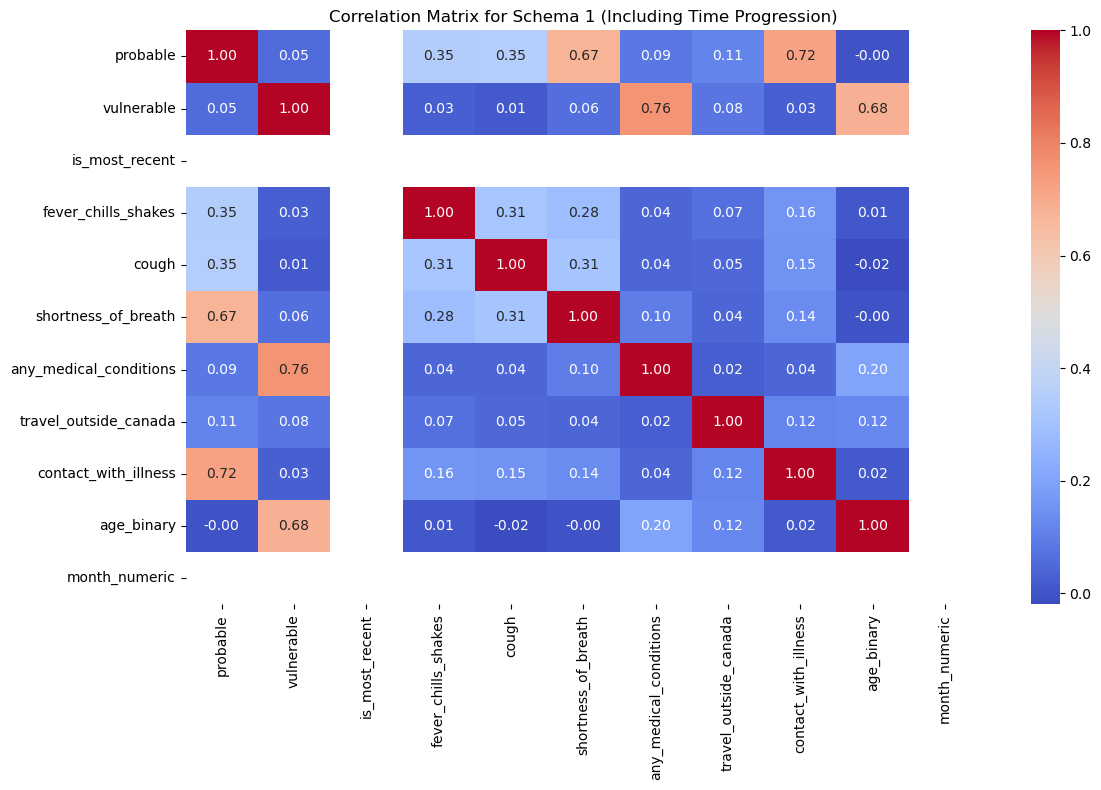

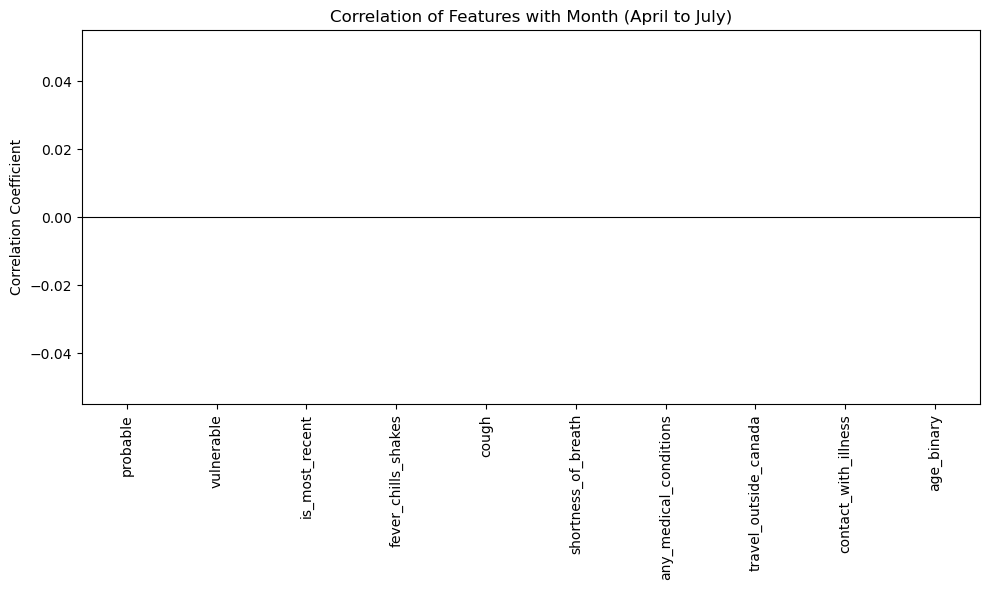

In [36]:
# how features correlate with the progression of time (the month).
# To do this, we must first map the months to numeric values.

month_map = {'April': 4, 'May': 5, 'June': 6, 'July': 7}
df1['month_numeric'] = df1['month'].map(month_map)

# Calculate the correlation matrix including the numeric month
# Note: fsa and age_1 are strings and will be ignored by .corr()
corr_matrix = df1.select_dtypes(include=['number']).corr()

# Extract the correlation of features with 'month_numeric'
# This shows how symptoms or risk factors trended over time.
month_correlations = corr_matrix['month_numeric'].sort_values(ascending=False)

# Visualization: Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Schema 1 (Including Time Progression)')
plt.tight_layout()
plt.savefig('df1_correlation_matrix.png')

# Visualization: Bar chart of correlations with month
plt.figure(figsize=(10, 6))
month_correlations.drop('month_numeric').plot(kind='bar', color='teal')
plt.title('Correlation of Features with Month (April to July)')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()


print("Correlation with Month (Time Trend):")
print(month_correlations)

# 2. DATA COMBINATION & CLEANING

# Define common clinical features for modeling

In [7]:

common_cols = [
    'month', 'probable', 'vulnerable', 'fever_chills_shakes', 'cough', 
    'shortness_of_breath', 'any_medical_conditions', 
    'travel_outside_canada', 'contact_with_illness', 'age_binary'
]

def prepare_and_align(df, cols):
    temp = df.copy()
    # Add missing columns as 0 (absence of symptom/condition)
    for col in cols:
        if col not in temp.columns:
            temp[col] = 0
    # Select only the target columns and drop any existing NaNs
    return temp[cols].dropna()

# Combine all datasets vertically
df_model = pd.concat([prepare_and_align(d, common_cols) for d in dfs], axis=0)

# Final safety check: fill any stray NaNs with 0 for binary columns
df_model = df_model.fillna(0)


# 3. MODEL PREPARATION

In [10]:
X = df_model.drop('probable', axis=1)
y = df_model['probable']

# Sampling for performance (KNN and Neural Networks are resource-intensive)
if len(df_model) > 50000:
    df_sample = df_model.sample(50000, random_state=42)
    X_final = df_sample.drop('probable', axis=1)
    y_final = df_sample['probable']
else:
    X_final, y_final = X, y

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)



# 4. BUILDING ROBUST PIPELINES (Handles NaNs automatically)

In [13]:

numeric_features = [c for c in X.columns if c != 'month']
categorical_features = ['month']

# Preprocessing step with Imputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define the three models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
}



# 5. EXECUTION AND EVALUATION

In [16]:
for name, clf in models.items():
    # Create the full pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', clf)])
    
    # Train the model
    model_pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    preds = model_pipeline.predict(X_test)
    print(f"\n--- {name} Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(classification_report(y_test, preds))




--- Logistic Regression Performance ---
Accuracy: 0.9989
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       0.98      1.00      0.99       452

    accuracy                           1.00     10000
   macro avg       0.99      1.00      0.99     10000
weighted avg       1.00      1.00      1.00     10000


--- KNN Performance ---
Accuracy: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       0.98      1.00      0.99       452

    accuracy                           1.00     10000
   macro avg       0.99      1.00      0.99     10000
weighted avg       1.00      1.00      1.00     10000


--- Neural Network Performance ---
Accuracy: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9548
           1       0.98      1.00      0.99       452

    accuracy                 

--- Decision Tree Extraction ---
|--- contact_with_illness <= 0.50
|   |--- shortness_of_breath <= 0.50
|   |   |--- cough <= 0.50
|   |   |   |--- class: 0
|   |   |--- cough >  0.50
|   |   |   |--- class: 1
|   |--- shortness_of_breath >  0.50
|   |   |--- any_medical_conditions <= 0.50
|   |   |   |--- class: 1
|   |   |--- any_medical_conditions >  0.50
|   |   |   |--- class: 1
|--- contact_with_illness >  0.50
|   |--- class: 1



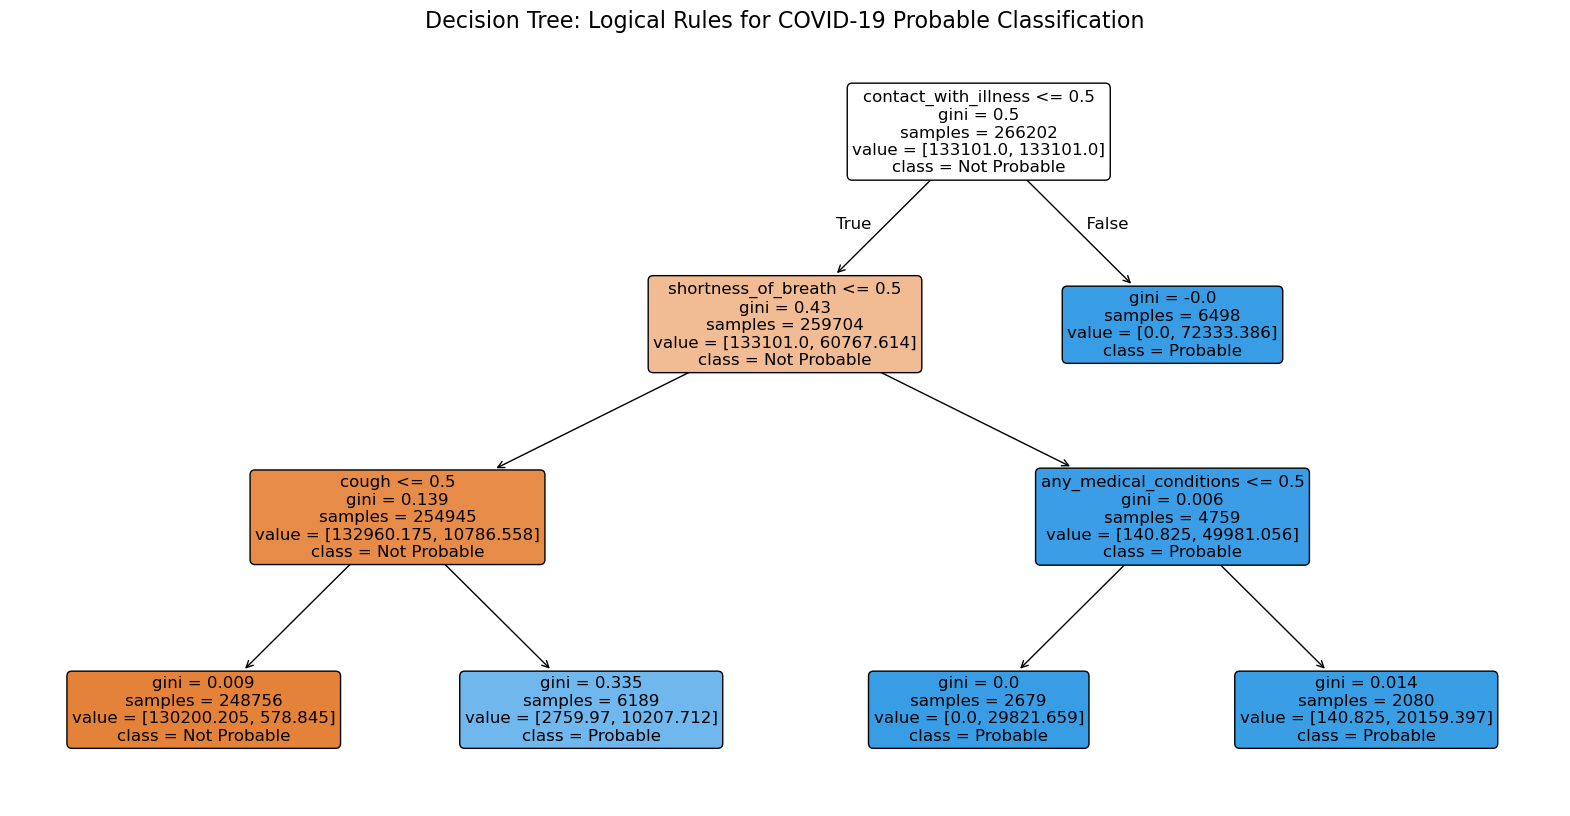

In [39]:
#1. Files
dfs = [pd.read_excel(f) for f in files]

# 2. Align Features and Combine Datasets
common_cols = [
    'probable', 'vulnerable', 'fever_chills_shakes', 'cough', 
    'shortness_of_breath', 'any_medical_conditions', 
    'travel_outside_canada', 'contact_with_illness', 'age_binary'
]

def align_df(df, cols):
    temp = df.copy()
    for col in cols:
        if col not in temp.columns:
            temp[col] = 0
    return temp[cols]

df_combined = pd.concat([align_df(d, common_cols) for d in dfs], axis=0).fillna(0)

# 3. Decision Tree Model Preparation
X = df_combined.drop('probable', axis=1)
y = df_combined['probable']

# Train with max_depth=3 for a clear, readable visualization
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42, class_weight='balanced')
dt_model.fit(X, y)

# 4. Visualization of the Decision Flow
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=['Not Probable', 'Probable'], 
          filled=True, 
          rounded=True, 
          fontsize=12)

plt.title("Decision Tree: Logical Rules for COVID-19 Probable Classification", fontsize=16)


# 5. Print the Exact Rules in Text Format
print("--- Decision Tree Extraction ---")
print(export_text(dt_model, feature_names=list(X.columns)))